<a href="https://colab.research.google.com/github/SpirinEgor/HSE.recommendation_systems/blob/master/homework_2/this_song_is_all_you_need.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab preparation

In [1]:
! nvidia-smi

Fri Nov 19 17:41:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install catboost

In [3]:
! git clone https://github.com/SpirinEgor/HSE.recommendation_systems
%cd HSE.recommendation_systems/homework_2

fatal: destination path 'HSE.recommendation_systems' already exists and is not an empty directory.
/content/HSE.recommendation_systems/homework_2


In [4]:
! git pull

Already up to date.


In [5]:
! mkdir data &&\
    cd data &&\
    wget https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz &&\
    tar -xzvf wsdm_data.tar.gz

mkdir: cannot create directory ‘data’: File exists


# Imports

In [6]:
from dataset import DatasetBuilder

import numpy as np
import seaborn as sns
from catboost import cv, CatBoostRanker
from tqdm.auto import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Basic recommendation system

In [7]:
dataset_builder = DatasetBuilder("data", 1023, 25)
dataset = dataset_builder.build_dataset()

Reading data...
Building embeddings for song...
	Building count vectors...
	Decomposing them with SVD...
	Explained variance of the SVD: 77%
Joining all data into one single table...
Removing users with too much songs...
Processing categorical features...


In [8]:
print("Categorical features: " + ", ".join(dataset.category_features))
dataset.features.head()

Categorical features: song_id, source_system_tab, source_screen_name, source_type, city, gender, registered_via, genre_ids, language


,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,language,song_emb_1,song_emb_2,song_emb_3,song_emb_4,song_emb_5,song_emb_6,song_emb_7,song_emb_8,song_emb_9,song_emb_10,song_emb_11,song_emb_12,song_emb_13,song_emb_14,song_emb_15,song_emb_16,song_emb_17,song_emb_18,song_emb_19,song_emb_20,song_emb_21,song_emb_22,song_emb_23,song_emb_24,song_emb_25
0,0,0,0,0,0,28,0,0,20120102,20171005,206471,0,0,0.913261,-0.068708,-0.094841,-0.034675,0.156423,-0.150219,-0.107551,0.062199,0.079589,-0.042486,0.017418,0.069391,0.099376,0.079655,-0.154786,0.010301,-0.040813,0.037707,-0.015647,-0.034635,0.117701,-0.040311,-0.023920,0.116047,0.031199
1,1,0,0,0,0,28,0,0,20120102,20171005,187802,1,0,0.851002,-0.055620,0.172773,-0.113189,-0.028599,0.090916,0.021551,0.071765,0.095901,-0.077888,0.089697,0.205822,-0.004729,-0.309982,-0.031592,-0.017751,-0.124730,-0.105279,-0.034866,0.078842,0.026714,0.067185,-0.093210,-0.054873,-0.035290
2,2,0,0,0,0,28,0,0,20120102,20171005,247803,2,0,0.827218,-0.078932,0.110917,0.162742,0.036988,0.076480,-0.323393,-0.122198,-0.063974,0.177387,-0.022776,-0.030657,-0.107359,0.094179,-0.067323,-0.000807,-0.051976,-0.076147,-0.232630,-0.006132,-0.029463,-0.007412,0.037708,-0.112340,-0.066288
3,3,0,0,0,0,28,0,0,20120102,20171005,181115,1,0,0.821057,-0.048121,-0.044837,-0.221009,-0.032184,0.081126,-0.151192,0.200196,0.141496,-0.256720,0.022953,0.287756,0.039639,0.114166,-0.001489,-0.049974,-0.090043,0.037037,-0.016833,-0.055145,0.010258,-0.042161,0.003804,0.030932,-0.011005
4,4,0,0,0,0,28,0,0,20120102,20171005,200713,3,0,0.906112,-0.066502,0.076949,-0.132817,-0.081697,-0.013248,-0.125531,-0.097822,0.084721,-0.026780,0.005788,0.027261,0.133294,-0.099032,-0.078109,0.107989,-0.088140,-0.059143,0.093498,-0.045716,-0.036650,0.172916,-0.078488,-0.068764,-0.023686


In [9]:
print(f"Number of unique users: {np.unique(dataset.user_id).shape[0]}")

Number of unique users: 30755


In [10]:
parameters = {
    "iterations": 150,
    "custom_metric": ["NDCG", "QueryAUC:type=Ranking"],
    "random_seed": 7,
    "loss_function": "YetiRank",
    "allow_writing_files": False,
    "verbose": False,
    "metric_period": 10,
    "task_type": "GPU"
}
eval_iterations = [
    i for i in range(parameters["iterations"])
    if i % parameters["metric_period"] == 0] + [parameters["iterations"] - 1
]

In [11]:
N_FOLDS = 5

scores = []
for train, test in tqdm(dataset.fold_split(N_FOLDS), "Cross-validation", N_FOLDS):
    train_pool = train.to_pool()
    test_pool = test.to_pool()
    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool)
    scores.append(model.get_evals_result())

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this cou

Final NDCG: 0.854 ± 0.002


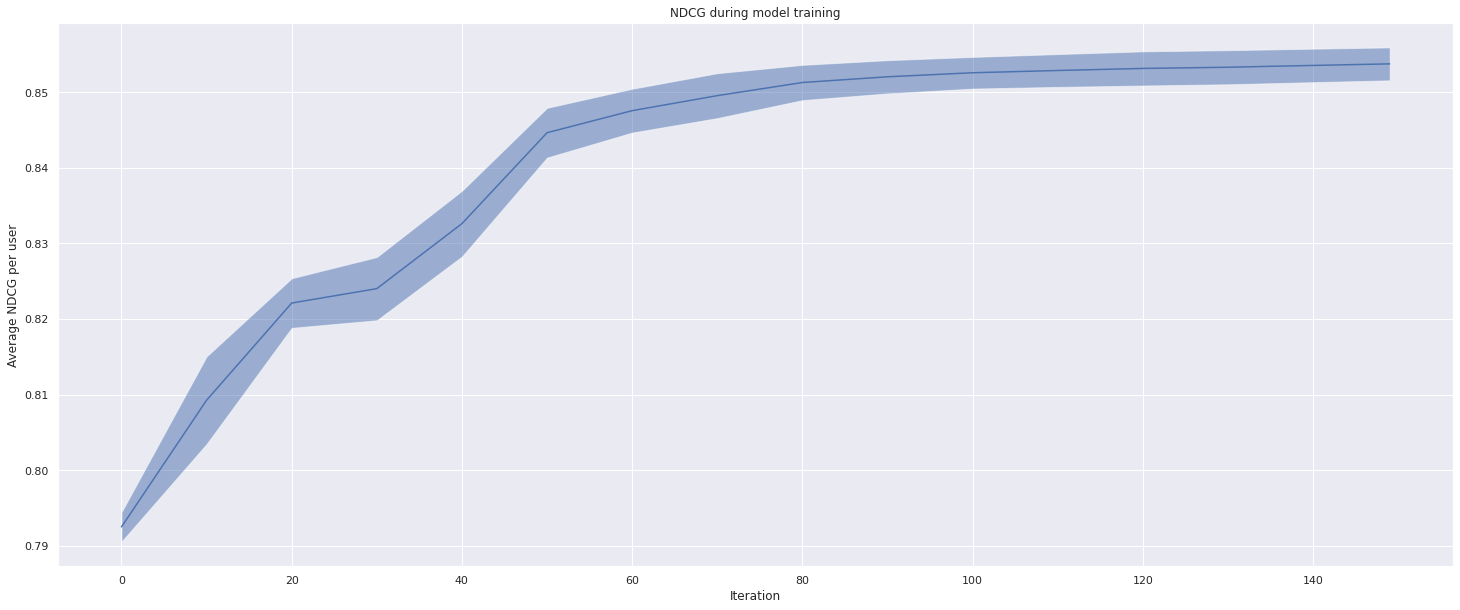

In [12]:
ndcgs = np.vstack([it["validation"]["NDCG:type=Base"] for it in scores])
m_ndcg = ndcgs.mean(axis=0)
s_ndcg = ndcgs.std(axis=0)

print(f"Final NDCG: {round(m_ndcg[-1], 3)} ± {round(s_ndcg[-1], 3)}")

sns.set_theme(rc={"figure.figsize": (25, 10)})

ax = sns.lineplot(x=eval_iterations, y=m_ndcg)
ax.set_title("NDCG during model training")
ax.set_ylabel("Average NDCG per user")
ax.set_xlabel("Iteration")
ax.fill_between(x=eval_iterations, y1=m_ndcg - s_ndcg, y2=m_ndcg + s_ndcg, alpha=.5)

Final ROC-AUC per user: 0.561 ± 0.001


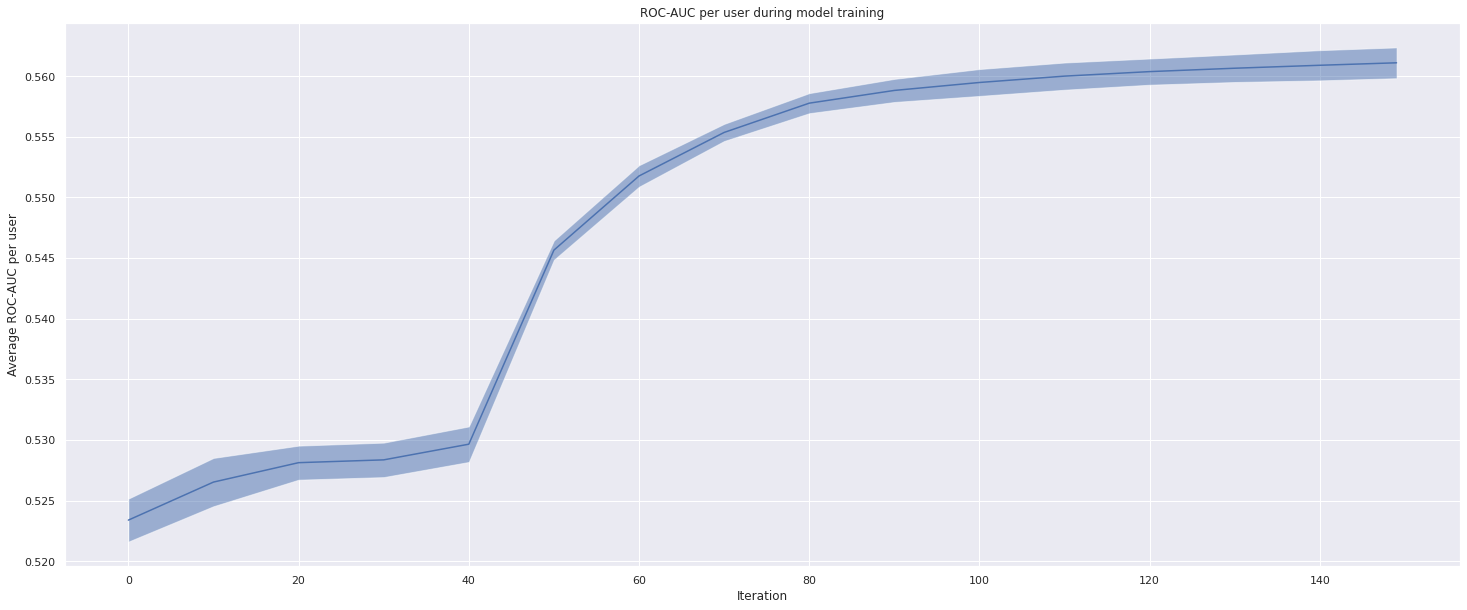

In [13]:
iterations = [i * 10 for i in range(10)] + [99]

aucs = np.vstack([it["validation"]["QueryAUC:type=Ranking"] for it in scores])
m_auc = aucs.mean(axis=0)
s_auc = aucs.std(axis=0)

print(f"Final ROC-AUC per user: {round(m_auc[-1], 3)} ± {round(s_auc[-1], 3)}")

sns.set_theme(rc={"figure.figsize": (25, 10)})

ax = sns.lineplot(x=eval_iterations, y=m_auc)
ax.set_title("ROC-AUC per user during model training")
ax.set_ylabel("Average ROC-AUC per user")
ax.set_xlabel("Iteration")
ax.fill_between(x=eval_iterations, y1=m_auc - s_auc, y2=m_auc + s_auc, alpha=.5)